## **Compressive Sensing and Deep Learning Framework**


We propose Compressive Sensing and Deep Learning framework (CS-DL) for multiple satellite sensor-based data fusion. We will use the data from three satellites, OCO2, OCO3 and GOSAT. We will be using Compressive Sensing to reconstruct xco2 data which was filtered from the data fusion of three satellites. Then using Deep Learning models, we will refine the xco2 data and further, improve the output data from the Compressive Sensing. To evaluate the model, we will compare how close our predicted data is to the original Satellite data.

**Motivation:** This work will help to increase satellite's coverage data, filling temporal gaps of the data which the satellite hasn't covered and managing the data when the instrument fails.

We will be taking reference of the paper:  IEEE_IGARSS_SATELLITE DATA FUSION OF MULTIPLE OBSERVED XCO2 USING COMPRESSIVE SENSING AND DEEP LEARNING.
Attached is the pdf.

**Data Links:**
1. OCO3 Satellite data: https://disc.gsfc.nasa.gov/datasets?keywords=OCO-3&page=1  
2. Gosat2 Satellite data: https://earth.esa.int/web/guest/-/gosat-2-tanso-fts-2-and-cai-2-full-archive-and-new-products
3. IEEE paper link: https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11423/114230Y/Satellite-data-fusion-of-multiple-observed-XCO2-using-compressive-sensing/10.1117/12.2558319.short?SSO=1


In [ ]:
import argparse
import time
!pip install netCDF4
from netCDF4 import Dataset
import os
import sys, getopt
from time import time
import pandas as pd
import numpy as np
from netCDF4 import num2date, date2num
import netCDF4
import datetime as dt
import glob
import csv
import h5py
from datetime import datetime
from pandas import Timestamp
import numpy.ma as ma
import fnmatch
from os import listdir
from os.path import isfile, join
import h5py
from IPython.display import Image
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

     |████████████████████████████████| 4.3MB 9.7MB/s 
     |████████████████████████████████| 296kB 42.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/MPDL Fall 2020/')

Mounted at /content/drive/


In [ ]:
#Compressive sensing libraries
import pywt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from dateutil import parser

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import time

from mpdl import train_simple_network, Flatten, weight_reset,train_network
from mpdl import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from torchsummary import summary

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### The work of the project has been divided into three parts.
1. Data Fusion
2. Compressive Sensing
3. Deep Learning

# Data Fusion

We have collected data from three Satellites namely Orbiting Carbon Observatory-2 (OCO-2), Orbiting Carbon Observatory-3 (OCO-3) and Greenhouse Gases Observing Satellite (GOSAT). The data file of OCO satellite is in netCDF format and GOSAT data files are in h5 format. We will be extracting datetime, latitude, longitude, xco2 values from these files and store them in a dataframe.

In [ ]:
def getOCOData(filePath, satelliteName):
    #This function take input path for OCO data files. Extract data from it return a dataframe
    files = [join(filePath, f) for f in listdir(filePath) if fnmatch.fnmatch(f, "*.nc4")] # Matching files format, netcdf (nc4) format
    dtime=[]
    latitude=[]
    longitude=[]
    xco2=[]
    dstype=[]
    files.sort()
    for file in files:
        rootgrp = Dataset(file, "r") #This is how we read the netcdf file
        times =  rootgrp.variables['time'] # Extracting time variable from the file and converting it to datetime
        units = times.units
        timeList = num2date(times[:],times.units)
        dtime = np.concatenate([dtime,timeList])
        latitude = ma.concatenate([latitude,rootgrp.variables['latitude'][:]]) # Extracting Latitude
        longitude = ma.concatenate([longitude,rootgrp.variables['longitude'][:]]) # Extracting Longitude
        xco2 = ma.concatenate([xco2,rootgrp.variables['xco2'][:]]) # Extracting xco2
    dstype = [satelliteName] * len(xco2) # Labeling the data row with satellite name

    df=pd.DataFrame({'dtime':dtime,'latitude':latitude,'longitude':longitude,'xco2':xco2,'dstype':dstype})
    return df

In [ ]:
def getGosatData(gosatFilePath,satelliteName):
    #The following code reads the GOSAT data files which are in h5 format and returns the dataframe
    gosatFiles = [join(gosatFilePath, f) for f in listdir(gosatFilePath) if fnmatch.fnmatch(f, "*.h5")]# Matching files format, h5
    dtime=[]
    latitude=[]
    longitude=[]
    xco2=[]
    dstype=[]  
    gosatFiles.sort()
    for file in gosatFiles:
        hf = h5py.File(file, 'r')#code to read the h5 files
        time=hf.get('scanAttribute/time/')[()]# Extracting time
        tmp_time=[]
        for t in time:
            tmp_time.append(pd.to_datetime(t.decode('UTF-8')))#Converting to datetime
        dtime = np.concatenate([dtime,tmp_time]) 
        latitude = ma.concatenate([latitude,hf.get('Data/geolocation/latitude')[()]]) # Extracting Latitude
        longitude = ma.concatenate([longitude,hf.get('Data/geolocation/longitude')[()]]) # Extracting Longitude
        xco2 = ma.concatenate([xco2,hf.get('scanAttribute/referenceData/XCO2')[()]]) # Extracting xco2
    dstype = [satelliteName] * len(xco2) # Labeling the data row with satellite name

    df=pd.DataFrame({'dtime':dtime,'latitude':latitude,'longitude':longitude,'xco2':xco2,'dstype':dstype})
    return df

In [ ]:
#Reading OCO3 data
oco3FilePath='/home/rgite1/Notebooks/AGU/Data/oco-3/'
oco3df = getOCOData(oco3FilePath,'oco3')

In [ ]:
#Reading OCO2 data
oco2FilePath='/home/rgite1/Notebooks/AGU/Data/oco-2/'
oco2df = getOCOData(oco2FilePath,'oco2')

In [ ]:
#Reading OCO3 data
gosatFilePath='/home/rgite1/Notebooks/AGU/Data/Gosat/'
gosatdf = getGosatData(gosatFilePath,'gosat')

**The above code takes huge time to run. In the first step, saving these dataframes in separate CSV files will save the time and helps in easier computation.**

In [ ]:
oco3df.to_csv('oco3.csv',index=False)
oco2df.to_csv('oco2.csv',index=False)
gosatdf.to_csv('gosat.csv',index=False)

In [ ]:
oco3=pd.read_csv('oco3.csv')
oco2=pd.read_csv('oco2.csv')
gosat=pd.read_csv('gosat.csv')

In [ ]:
oco3['dtime']= pd.to_datetime(oco3['dtime'])
oco2['dtime']= pd.to_datetime(oco2['dtime'])
gosat['dtime']= pd.to_datetime(gosat['dtime'])

**Let's look into the data**

In [ ]:
oco3.describe()

,latitude,longitude,xco2
count,3.918826e+07,3.918826e+07,3.918826e+07
mean,1.333458e+01,7.988348e+00,4.110489e+02
std,2.892117e+01,9.474607e+01,4.136938e+00
min,-5.222667e+01,-1.800000e+02,3.013579e+02
25%,-1.354395e+01,-6.884496e+01,4.088957e+02
50%,2.060363e+01,1.956677e+01,4.109680e+02
75%,3.853177e+01,8.226374e+01,4.134531e+02
max,5.358460e+01,1.800000e+02,6.890504e+02


In [ ]:
oco2.describe()

,latitude,longitude,xco2
count,7.024274e+07,7.024274e+07,7.024274e+07
mean,4.855555e+00,-1.572636e+00,4.102738e+02
std,3.244522e+01,1.070118e+02,3.720491e+00
min,-8.611964e+01,-1.800000e+02,3.040264e+02
25%,-2.016225e+01,-1.028060e+02,4.087037e+02
50%,6.750165e+00,4.598218e+00,4.102871e+02
75%,2.942220e+01,8.845598e+01,4.122330e+02
max,8.186852e+01,1.800000e+02,4.731941e+02


In [ ]:
gosat.describe()

,latitude,longitude,xco2
count,113574.000000,113574.000000,113574.000000
mean,10.116607,4.649603,407.471651
std,31.235879,94.025689,1.922483
min,-56.254173,-179.983078,398.186859
25%,-19.862154,-71.287302,406.289986
50%,16.119309,15.792614,407.378769
75%,36.129657,79.840599,408.528526
max,82.170624,179.996582,416.266693


In [ ]:
oco3.head()

,dtime,latitude,longitude,xco2,dstype
0,2019-08-31 00:00:43.256011,39.122433,150.874939,402.104797,oco3
1,2019-08-31 00:00:43.310004,39.133327,150.923019,403.095856,oco3
2,2019-08-31 00:00:43.562990,39.104202,150.871765,408.066071,oco3
3,2019-08-31 00:00:43.590027,39.109531,150.895706,407.496765,oco3
4,2019-08-31 00:00:43.617023,39.114983,150.919891,406.105988,oco3


In [ ]:
oco2.head()

,dtime,latitude,longitude,xco2,dstype
0,2019-08-31 00:21:48.921003,-52.655556,-155.037903,408.210968,oco2
1,2019-08-31 00:21:49.920997,-52.603539,-155.053604,408.518707,oco2
2,2019-08-31 00:22:31.254992,-50.407444,-155.714569,408.754547,oco2
3,2019-08-31 00:22:37.562018,-50.075825,-155.782959,408.632660,oco2
4,2019-08-31 00:22:56.696012,-49.042381,-156.222504,407.488434,oco2


In [ ]:
gosat.head()

,dtime,latitude,longitude,xco2,dstype
0,2020-02-01 01:01:41.020,-24.135565,174.750168,406.025726,gosat
1,2020-02-01 01:03:50.084,-31.232861,172.859680,405.820251,gosat
2,2020-02-01 01:03:54.609,-31.484879,172.788452,405.834961,gosat
3,2020-02-01 01:03:59.303,-31.737278,172.716751,405.850372,gosat
4,2020-02-01 01:04:03.828,-31.988190,172.645096,405.860779,gosat


**Now lets combine these three dataframes to create a single dataframe**

In [ ]:
frames = [oco3, oco2, gosat]
df_combine = pd.concat(frames)

In [ ]:
# Changing dtime to datetime
df_combine['dtime']= pd.to_datetime(df_combine['dtime'])

**The above dataframe consists of data all over the globe, but the point of focus in this project is for the area of the United States. Based on the Latitude and Longitude points, data for the just US is taken.**

In [ ]:
minLat = 25.313
maxLat = 51.328
maxLon = -127.266
minLon = -61.172
df_combine = df_combine[(df_combine.latitude >= minLat) & (df_combine.latitude <= maxLat)]
df_combine = df_combine[(df_combine.longitude >= maxLon) & (df_combine.longitude <= minLon)]

**More data has to be refined as the GOSAT data available from Feb to Sept 2020. So the data is taken from the dates of 2020-02-01 to 2020-09-30 for all the three Satellites.**

In [ ]:
start_date = "2020-02-01"
end_date = "2020-09-30"
filtered_dates = df_combine[(df_combine.dtime >= start_date) & (df_combine.dtime <= end_date)]

In [ ]:
filtered_dates.to_csv('combineData_20200201_20200930_US.csv',index=False)

Visualizing the Data

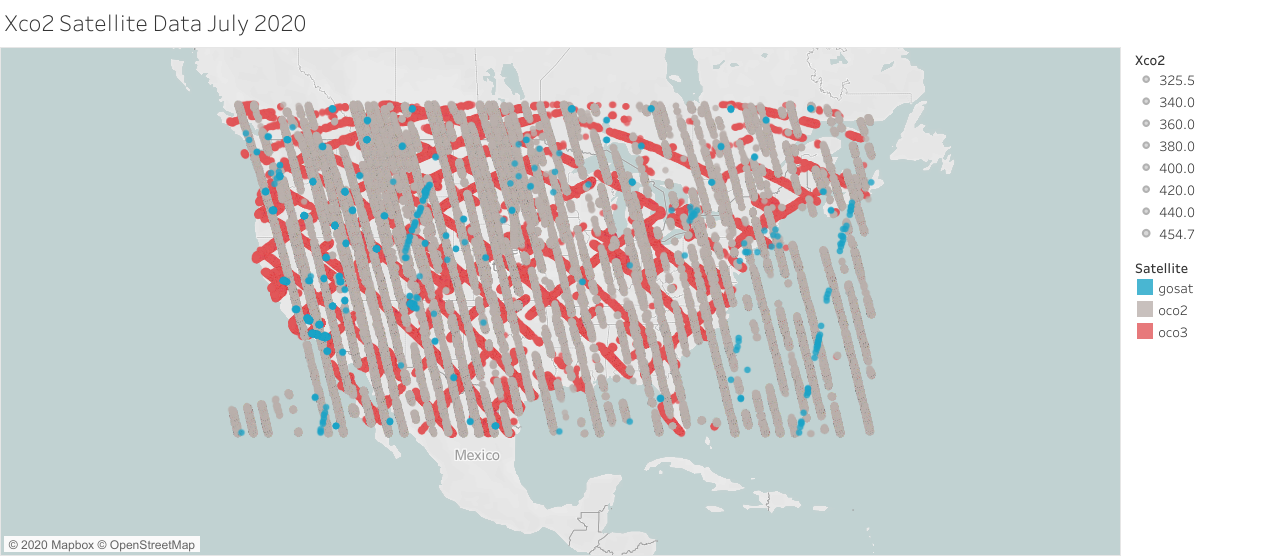

In [ ]:
# The map is plotted over the one month of data i.e., July 2020. Tableau was used to create this plot.
# From this image we can see that the xco2 value lies between range on 325 to 454 meters. 
# And we have comparitively less data for GOSAT Satellite compare to OCO-2 & 3
Image(filename='map.png') 

In [ ]:
df=pd.read_csv('combineData_20200201_20200930_US.csv')

**XCO2 is the column-averaged of carbon dioxide in the atmosphere, represented in parts per million. The range of xco2 values lies between 390 and 430. The remaining values are outliers and subsequently they should be filtered out.**

In [ ]:
min_val=390
max_val=430
df = df[df['xco2']>min_val]
df = df[df['xco2']<max_val]

In [ ]:
df.shape

(4523692, 5)

# Part 2: Compressive Sensing
Compressed sensing (also known as compressive sensing, compressive sampling, or sparse sampling) is a signal processing technique for efficiently acquiring and reconstructing a signal, by finding solutions to underdetermined linear systems. This is based on the principle that, through optimization, the sparsity of a signal can be exploited to recover it from far fewer samples than required by the Nyquist–Shannon sampling theorem. 
Source:https://en.wikipedia.org/wiki/Compressed_sensing

In this part, we will randomly filter 20% of our data and then with this 20% of data will try to generate the data similar to orignal data using compressive sensing.

**Few points to consider:** The dataset has too many data points. We are going to average out 2min of data. Assume that it is like a satellite which is trying to capture the data from point A to B on earth in 2min. In this case we will be having 'n' number of data points between A and B. We will average out all the 'n' data points to a single data point.

In [ ]:
def dynamicAVG(df,interval):
    #Input to this method is the dataFrame and the time interval string to which we want to average the dataout. 
    df['dtime']= pd.to_datetime(df['dtime'])
    #df['dtime'] = df['dtime'].values.astype('<M8[m]')#removeing second and mili second from datetime
    df=df.set_index(df['dtime'])#setting index as dtime
    df_interval = df.groupby(pd.Grouper(freq=interval)).mean() # this line will group the data and take the mean based on interval
    df_interval=df_interval.dropna()#groupby will create some null values so removing them
    df_interval.reset_index(level=0, inplace=True) #returning the dataframe after resetting the index
    return df_interval

In [ ]:
oco3 = df[df['dstype']=='oco3']
oco2 = df[df['dstype']=='oco2']
gosat = df[df['dstype']=='gosat']

In [ ]:
interval='2Min'
oco3_2min =  dynamicAVG(oco3,interval) 
oco2_2min =  dynamicAVG(oco2,interval)
gosat_2min =  dynamicAVG(gosat,interval)

/home/rgite1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
oco3_2min.head()

,dtime,latitude,longitude,xco2
0,2020-02-08 14:58:00,26.457648,-66.192075,412.501658
1,2020-02-08 15:00:00,28.335299,-64.140916,413.299662
2,2020-02-08 16:32:00,26.852684,-90.385914,413.765468
3,2020-02-08 16:34:00,39.227245,-75.611072,416.215672
4,2020-02-08 16:36:00,39.638576,-75.256604,414.993423


In [ ]:
oco2_2min.head()

,dtime,latitude,longitude,xco2
0,2020-02-01 17:54:00,45.842412,-73.463290,412.765733
1,2020-02-01 17:56:00,46.620649,-73.771170,402.549736
2,2020-02-01 19:30:00,29.579189,-95.911845,414.162622
3,2020-02-01 19:32:00,33.799057,-97.312406,413.614101
4,2020-02-01 19:36:00,50.105625,-104.616992,417.117164


In [ ]:
gosat_2min.head()

,dtime,latitude,longitude,xco2
0,2020-02-01 20:22:00,34.485746,-107.900795,407.631027
1,2020-02-01 20:24:00,31.185057,-104.524216,407.812286
2,2020-02-02 19:16:00,38.779920,-85.042508,408.433611
3,2020-02-02 19:18:00,32.205733,-87.503904,408.354029
4,2020-02-02 20:56:00,33.730276,-117.299658,408.767711


In [ ]:
frames = [oco3_2min, oco2_2min, gosat_2min]
df_Avg = pd.concat(frames)

In [ ]:
df_Avg.reset_index(drop=True, inplace=True)

**The below function will perform Compressive sensing**

In [ ]:
def compressiveSensing(df):
    #This function will take input our dataframe, Fileter data into 20%, and reconstruct the xco2 signal and return it

    w = pywt.Wavelet('db2')  # Defines a wavelet object - 'db2' default defines a Daubechies wavelet
    # Multilevel decomposition of the input data
    y=df['xco2']
    coeffs = pywt.wavedec(y, w, level=6) #Multilevel 1D Discrete Wavelet Transform of data
    y_wavelet =pywt.waverec(coeffs[:-1] + [None] * 1, w)# Multilevel 1D Inverse Discrete Wavelet Transform.


    n=df.shape[0]
    sample_percent = 20 #percent of data we want to filter out
    m = int(sample_percent * n/100)
    ri = np.random.choice(df.shape[0], m,replace=False).astype(int)# randomly picking out the index
    ri.sort()


    # wavelet
    y2 = y_wavelet[ri]

    A = spfft.idct(np.identity(n, dtype='int8'), norm='ortho', axis=0)#Return the Inverse Discrete Cosine Transform of an arbitrary type sequence.

    A = A[ri]
    # CVXPY is a Python-embedded modeling language for convex optimization problems. 
    # It automatically transforms the problem into standard form, calls a solver, and unpacks the results.
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))


    constraints = [A*vx == y2]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=True)

    # Reconstruct signal using discret cosin transformation
    l1 = np.array(vx.value)
    l1 = np.squeeze(l1)
    sig = spfft.idct(l1, norm='ortho', axis=0)

    return sig

In [ ]:
reconstructed_xco2 = compressiveSensing(df_Avg)

/home/rgite1/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:523: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.670e-20  -0.000e+00  +5e+07  1e+00  1e-02  1e+00  4e+03    ---    ---    1  1  - |  -  - 
 1  +3.525e+04  +3.550e+04  +3e+07  1e+00  6e-03  3e+02  2e+03  0.5419  1e-01   1  1  1 |  0  0
 2  +3.089e+04  +3.153e+04  +1e+07  7e-01  2e-03  6e+02  7e+02  0.9890  3e-01   1  0  0 |  0  0
 3  +3.545e+04  +3.547e+04  +3e+05  4e-02  6e-05  2e+01  2e+01  0.9706  3e-04   1  0  0 |  0  0
 4  +3.616e+04  +3.617e+04  +1e+05  1e-02  2e-05  7e+00  8e+00  0.6483  6e-02   1  0  0 |  0  0
 5  +3.699e+04  +3.699e+04  +8e+04  1e-02  2e-05  5e+00  5e+00  0.5196  3e-01   1  1  1 |  0  0
 6  +3.805e+04  +3.805e+04  +3e+04  4e-03  7e-06  2e+00  2e+00  0.6069  1e-01   1  0  1 |  0  0
 7  +3.941e+04  +3.941e+04  +1e+04  2e-03  3e-06  9e-01  9e-01  0.6505  7e-02   1  0  0 |  0  0
 8  +4.012e+04  +4.012e+04  +7e+03  8e-04  1e-

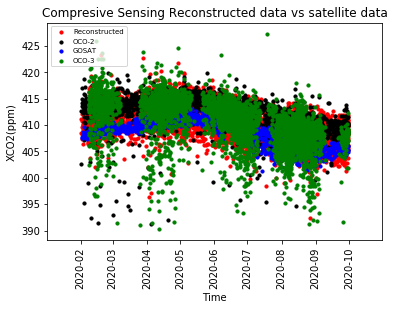

In [ ]:

dtime=df_Avg['dtime']
dtime_oco3 = oco3_2min['dtime']
dtime_oco2 = oco2_2min['dtime']
dtime_gosat = gosat_2min['dtime']
yoco3 = oco3_2min['xco2']
yoco2 = oco2_2min['xco2']
ygosat = gosat_2min['xco2']
f,a=plt.subplots()
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('XCO2(ppm)')


a.scatter(dtime,reconstructed_xco2,color='r',label='Reconstructed',s=10)
a.scatter(dtime_oco2,yoco2,color='k',label='OCO-2',s=10)
a.scatter(dtime_gosat,ygosat,color='b',label='GOSAT',s=10)
a.scatter(dtime_oco3,yoco3,color='g',label='OCO-3',s=10)
a.legend(loc='upper left',fontsize = 7)
plt.title('Compresive Sensing Reconstructed data vs satellite data')
plt.savefig('Compresive Sensing Reconstructed data vs satellite data_wavelet_oco-3_oco-2_gosat.png')

**The result looks good. We are able to generate the core of the data. One interesting aspect is that for OCO-3, we don't have some chunks of data, but still thanks to compressive sensing and data fusion we are able to generate that as well.**

In [ ]:
df_Avg['Reconstructed'] = reconstructed_xco2

In [ ]:
df_Avg.head()

,dtime,latitude,longitude,xco2,Reconstructed
0,2020-02-08 14:58:00,26.457648,-66.192075,412.501658,412.618489
1,2020-02-08 15:00:00,28.335299,-64.140916,413.299662,412.015694
2,2020-02-08 16:32:00,26.852684,-90.385914,413.765468,413.516531
3,2020-02-08 16:34:00,39.227245,-75.611072,416.215672,416.368738
4,2020-02-08 16:36:00,39.638576,-75.256604,414.993423,416.249403


**Regression analysis parameters:**
1. R-squared is a relative measure of fit, R-squared is around 35% reveals that 35% of the data fits the regression model.      
2. RMSE is an absolute measure of fit. Lower values of RMSE indicate better fit. 

In [ ]:
r2 = r2_score(df_Avg['xco2'],df_Avg['Reconstructed'])
rmse = sqrt(mean_squared_error(df_Avg['xco2'],df_Avg['Reconstructed']))

In [ ]:
print("r2 Score :"+str(r2))
print("rmse Score :"+str(rmse))

r2 Score :0.3577446190006697
rmse Score :3.3105890558891504


In [ ]:
690 # quickley save the file before notebook go down
df_Avg.to_csv('combined_reconstructed_avgBy2Min_wavelet_US_oco2,3_gosat.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL_690/Project/combined_reconstructed_avgBy2Min_wavelet_US_oco2,3_gosat.csv')

In [ ]:
df.head()

,Unnamed: 0,dtime,latitude,longitude,xco2,Reconstructed
0,0,2020-02-08 14:58:00,26.457648,-66.192075,412.501658,412.141138
1,1,2020-02-08 15:00:00,28.335299,-64.140916,413.299662,414.254989
2,2,2020-02-08 16:32:00,26.852684,-90.385914,413.765468,410.925503
3,3,2020-02-08 16:34:00,39.227245,-75.611072,416.215672,412.272613
4,4,2020-02-08 16:36:00,39.638576,-75.256604,414.993423,416.143529


In [ ]:
df.shape

(7452, 6)

# Part 3 - Deep Learning
As we can see above we have our orignal xco2 data and compressive sensing Reconstructed Data. Now further we will try to improve this result through Deep Learning. We will be doing regression analysis to predict xco2 data from our reconstructed data. To do this we will use Recurrent Neural Network (RNN) GRU layers and Artificial Neural Network (ANN) Dense layer. 
The reason to use RNN is that the data we have is Time Series and we want our network remember the old time data while making prediction for new data.

In [ ]:
#Getting rid of other columns
df=df.iloc[:,4:]
df.head()

,xco2,Reconstructed
0,412.501658,412.141138
1,413.299662,414.254989
2,413.765468,410.925503
3,416.215672,412.272613
4,414.993423,416.143529


**To help our model learn we will standardize the data by transforming our data such that its distribution will have a mean value 0 and standard deviation of 1.**

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
df_Scaled = pd.DataFrame(scaled)
df_Scaled.head()

,0,1
0,0.600820,0.644694
1,0.622391,0.713776
2,0.634983,0.604966
3,0.701217,0.648991
4,0.668177,0.775495


**Now lets prepare the data for our model.**

In [ ]:
def load_n_split_data(input_df, seq_len, split_percent, predict_col_num):
    # This function will split the data into training and testing set.
    # Also arrange the data into 3D fashion, which is how we give input to RNN
    amount_of_features = len(input_df.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = input_df.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length):        # maxmimum = lastest - sequence length
        result.append(data[index: index + sequence_length]) # index : index + sep len

    result = np.array(result)
    row = round( split_percent* result.shape[0]) # split_percent e.g 0.8 = 80% split
    print ("Amount of training+val data = {}".format(split_percent * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split_percent) * result.shape[0]))

    train = result[:int(row), :]    # upto split_percent 
    X_train = train[:, :-1]         # all data until split_percent
    y_train = train[:, predict_col_num][:,predict_col_num]      # Predict column number, must specify correctly

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, predict_col_num][:,predict_col_num]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))  
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))    

    return [torch.FloatTensor(X_train), torch.FloatTensor(y_train), torch.FloatTensor(X_test), torch.FloatTensor(y_test)]

In [ ]:
## Performing the loading and splitting of the data
seq_len=3
split_percent=0.8
predict_col_num=0
train_X, train_y, test_X, test_y= load_n_split_data(df_Scaled, seq_len, split_percent, predict_col_num)

Amount of features = 2
Amount of training+val data = 5958.400000000001
Amount of testing data = 1489.5999999999997


In [ ]:
train_X=train_X[:,:,-1]
test_X=test_X[:,:,-1]

In [ ]:
print("train_X shape: "+str(train_X.shape))
print("train_X shape: "+str(train_y.shape))

train_X shape: torch.Size([5958, 3])
train_X shape: torch.Size([5958])


In [ ]:
train_X

tensor([[0.6447, 0.7138, 0.6050],
        [0.7138, 0.6050, 0.6490],
        [0.6050, 0.6490, 0.7755],
        ...,
        [0.4844, 0.4361, 0.5829],
        [0.4361, 0.5829, 0.5781],
        [0.5829, 0.5781, 0.6186]])

In [ ]:
train_y

tensor([0.6008, 0.6224, 0.6350,  ..., 0.4452, 0.5782, 0.5122])

**Now we have our dataset, but we need it in a form that PyTorch will understand. With below code we will create our dataset and reshape it to 3D. We will feed it into Dataloader and obtain training_loader and test_loader.**

In [ ]:
from torch.utils.data import Dataset, DataLoader
class GetDataset(Dataset):
        
    def __init__(self, X, y):
        super(GetDataset, self).__init__()
        self.X = X.reshape(X.shape[0], X.shape[1], 1)
        self.y = y.reshape(-1,1)
        
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
training_loader = DataLoader(GetDataset(train_X, train_y), shuffle=True)

In [ ]:
#training data shape
training_loader.dataset.X.shape

torch.Size([5958, 3, 1])

In [ ]:
#Testing loader
test_loader = DataLoader(GetDataset(test_X, test_y), shuffle=False)

In [ ]:
inputSize=len(train_X)

rnn_layer = nn.Sequential( 
  nn.GRU(1,100, num_layers=3, batch_first=True),#(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3),#We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(100,100),
  nn.ReLU(),
  nn.Dropout(),
  nn.Linear(100, 1)
)

In [ ]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_layer.parameters(),lr=0.0015)
results = train_network(rnn_layer, loss_func, training_loader, val_loader=test_loader,test_loader=test_loader,optimizer=optimizer, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
results.tail()

,epoch,total time,train loss,val loss,test loss,train Accuracy,val Accuracy,test Accuracy
25,25,1234.670671,0.009327,0.002367,0.002367,NaN,NaN,NaN
26,26,1289.042202,0.009270,0.002463,0.002463,NaN,NaN,NaN
27,27,1342.182433,0.009355,0.002878,0.002878,NaN,NaN,NaN
28,28,1395.908941,0.009226,0.002418,0.002418,NaN,NaN,NaN
29,29,1450.468189,0.009166,0.002318,0.002318,NaN,NaN,NaN


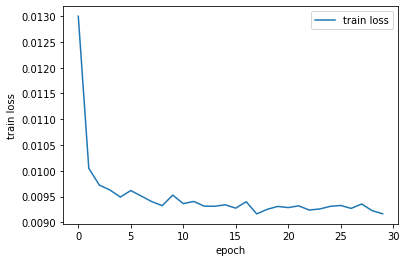

In [ ]:
#plotting the training loss
sns.lineplot(x='epoch', y='train loss', data=results, label='train loss')

**Making prediction**

In [ ]:
test_X=test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X=test_X.to(device)

In [ ]:
with torch.no_grad():
    Y_pred = rnn_layer(test_X).cpu().numpy()

In [ ]:
r2 = r2_score(test_y,Y_pred)
rmse = sqrt(mean_squared_error(test_y,Y_pred))

**r-squared is around 50% reveals that 50% of the data fit the regression model.
RMSE is also much lower.**

In [ ]:
print("r2 Score :"+str(r2))
print("rmse Score :"+str(rmse))

r2 Score :0.48434266885537447
rmse Score :0.048150440476303964


**Comparing this with the R-Squared and RMSE of Compressive Sensing which was R-Squared:0.35 and RMSE:3.31. Here we have significantly improved our work and we are much more closer to actual data.**

In [ ]:
#This code will denormalize our predicted data, so we can compare it to our orignal data
def denormalized(origin_data, output_data):
    max_value=origin_data.max()
    min_value=origin_data.min()
    return output_data*(max_value-min_value)+min_value

In [ ]:
pr_o=np.array(Y_pred)
pr_o=pr_o.reshape(1,len(Y_pred))
predicted_de=denormalized(df['xco2'], Y_pred)

In [ ]:
expected_de=denormalized(df['xco2'], test_y)

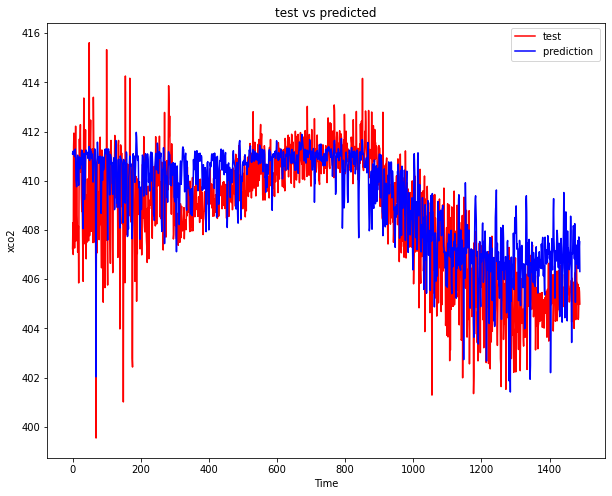

In [ ]:
plt.figure(figsize=(10,8))
plt.title('test vs predicted')
plt.xlabel('Time')
plt.ylabel('xco2')
plt.plot(expected_de, 'r', label='test')
plt.plot(predicted_de, 'b', label='prediction ')
plt.legend()
plt.savefig('Test vs predicted data.png')
plt.show()

**We have been able to capture the curve of our testing dataset. In the beginning, the curve might missed some data points but along the datatset, it predicted almost similar data.**

# **Conclusion:**
### We could build a Compressive Sensing and Deep Learning frame work with data fusion of three satellite data. In a situation where there is not enough data from the satellite the scientist can use this framework to generate full dataset and use it in their scientific studies.

## **This work was also presented at American Geophysical Union (AGU) Fall 2020 Meeting. AGU community work to promote discovery in Earth and space science.**

# Future Work: 

1.   We could add one more satellite data ie GOSAT-2.
2.   For this work we acquired data of 9 months. There is a chance that the model will perform better if we feed more data to it.
3. We could use different Deep Learning architectures and fine tune of model to get better result.


